# Step 2: Feature Engineering

模型的目标是根据用户的第一次购买信息来预测是否会再次购买。

在上一步中，我们发现各商品是有类别的，不同的用户关注的商品类别是不同的，因此首先我们把商品根据关键词分门别类。

## 2.1 商品分类

In [1]:
# 导入相关modules
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


In [18]:
# 导入数据
df = pd.read_csv('./temp/cleaned_data.csv')
keywords = np.load('./temp/keywords.npy')[:193]

这里一共有295个关键词

如何分类？

用独热编码并用稀疏矩阵记录下来。

$$
 X = \left(\begin{matrix}
   x_{11} & x_{12} & x_{13} & \dots & x_{1M}\\
   x_{21} & x_{22} & x_{23} & \dots & x_{2M} \\
   \vdots & \vdots & \vdots & \vdots & \vdots \\
   x_{N1} & x_{N2} & x_{N3} & \dots & x_{NM}
  \end{matrix}\right) 
$$

其中$x_{nm}$表示第n商品中含有第m个关键词

In [28]:
# 创建稀疏矩阵
df["Description"] = df["Description"].apply(lambda l: l.lower())
description_diff = df["Description"].unique()
X = pd.DataFrame()
for key in keywords:
    X.loc[:, key] = list(map(lambda x: int(key in x), description_diff))

In [29]:
display(X.head(4))
display(description_diff[:4])

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,plant,diner,house,square,lace,wallet,point,flag,circus,bin
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


array(['white hanging heart t-light holder', 'white metal lantern',
       'cream cupid hearts coat hanger',
       'knitted union flag hot water bottle'], dtype=object)

与此同时，由于价格也带着商品类别的信息，比如同类别的商品具有相近的价格。因此我们在特征矩阵$X$上再增加价格区间特征。

In [30]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
list_products = df['Description'].unique()
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_products):
    prix = df[df['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [31]:
print("{:<8} {:<20} \n".format('区间', '商品数量') + 20 * '-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

区间       商品数量                 
--------------------
0<.<1       963                 
1<.<2       1006                
2<.<3       673                 
3<.<5       606                 
5<.<10      468                 
.>10        149                 


接下来对不同商品之间特征距离的刻画并以此来聚类，这里我们采取k-means方法，距离用sklearn默认的欧氏距离。

In [32]:
matrix = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10075924863157419
For n_clusters = 4 The average silhouette_score is : 0.12633012617972553
For n_clusters = 5 The average silhouette_score is : 0.14742736262909106
For n_clusters = 6 The average silhouette_score is : 0.13186045135004174
For n_clusters = 7 The average silhouette_score is : 0.1498427084932894
For n_clusters = 8 The average silhouette_score is : 0.1537415455901915
For n_clusters = 9 The average silhouette_score is : 0.1410900689119228


可以看到当用K-Means算法分成5组时，在silhouette_score的意义下最好。因此我们选择分成5组，接下来看一下每组中含有词的情况

In [34]:
n_clusters = 5
silhouette_avg = 0
while silhouette_avg < 0.14:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print(silhouette_avg)
print(silhouette_avg)

0.12695405524480535
0.14742736262909106
0.14742736262909106


In [35]:
pd.Series(clusters).value_counts()

4    1006
3     963
2     673
0     617
1     606
dtype: int64

In [36]:
list_des = pd.DataFrame(description_diff)

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = list_des.loc[clusters == i]
    for word in keywords:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word))

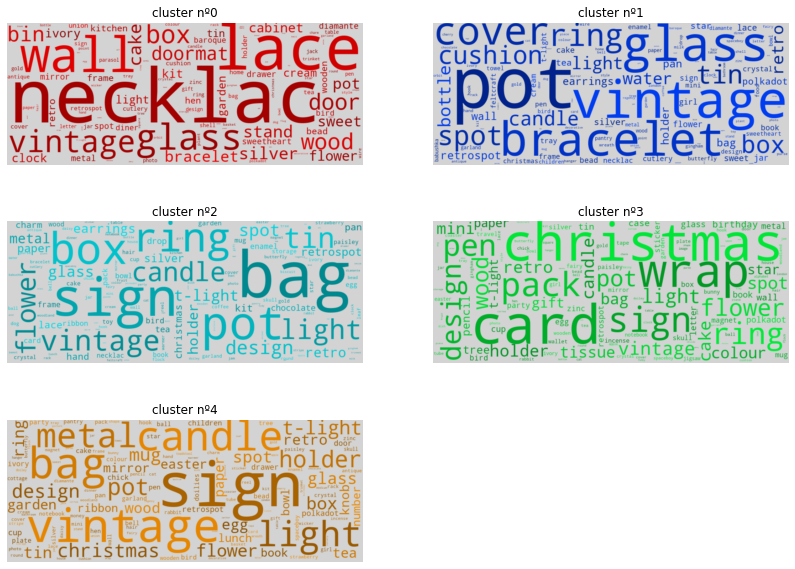

In [37]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))

fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)       

通过K-means算法聚类后，这里我们可以看到一些合理性，例如一组跟礼物有关(keywords: Christmas, packaging, card, ...), 有一组跟首饰有关(keywords: necklace, bracelet, lace, silver, ...)。但是还是很多词同时出现在多个组中，这是一个后期可以优化的地方。